In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import lsst.daf.persistence        as dafPersist

import lsst.afw.display            as afwDisplay
import lsst.daf.base               as dafBase

import lsst.afw.image              as afwImage
import lsst.afw.geom               as afwGeom
import lsst.afw.table              as afwTable

import lsst.meas.algorithms        as measAlg

#### Load the high-level "tasks" that process the pixels

In [3]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

#### Setup the displays (by default an interface to ds9)

In [4]:
disp  = afwDisplay.Display(1)
disp2 = afwDisplay.Display(2)

## Create the tasks

In [5]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask =         CharacterizeImageTask(None, config=config)

sourceDetectionTask =   SourceDetectionTask(schema=schema)

sourceDeblendTask =     SourceDeblendTask(schema=schema)

if False:
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                       algMetadata=algMetadata)
else:
    config = SingleFrameMeasurementTask.ConfigClass()
    config.slots.apFlux = 'base_CircularApertureFlux_12_0'
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                       algMetadata=algMetadata)

## Time to process some data

#### Read the input data

In [6]:
butler = dafPersist.Butler("/Volumes/RHLData/hsc-v13_0")

In [7]:
dataId = dict(visit=29352, ccd=50)
exposure = butler.get('calexp', dataId)

#### Create the output table

In [8]:
tab = afwTable.SourceTable.make(schema)

### Process the pixels

##### Characterise the exposure (e.g. estimate the PSF)

In [9]:
result = charImageTask.characterize(exposure)

##### Detect objects (`sources')

In [10]:
result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

##### Deblend overlapping objects

In [11]:
sourceDeblendTask.run(exposure, sources)

##### Measure the objects' properties

In [12]:
sourceMeasurementTask.run(exposure, sources)

#### Write the results to a FITS file (if desired)

In [24]:
if False:
    fitsTableFile = "outputTable.fits"
    sources.writeFits(fitsTableFile)

    exposure.writeFits("example1-out.fits")
else:
    fitsTableFile = None

## OK, we've finished the image processing.

We have our list of sources, but it's not currently continuous in memory

In [14]:
try:
    sources.get("id")
except Exception as e:
    print e


  File "include/lsst/afw/table/BaseColumnView.h", line 207, in static lsst::afw::table::BaseColumnView lsst::afw::table::BaseColumnView::make(const std::shared_ptr<BaseTable> &, InputIterator, InputIterator) [InputIterator = lsst::afw::table::CatalogIterator<std::__1::__wrap_iter<const std::__1::shared_ptr<lsst::afw::table::SourceRecord> *> >]
    Record data is not contiguous in memory. {0}
lsst::pex::exceptions::RuntimeError: 'Record data is not contiguous in memory.'



We can fix this with a deep copy

In [15]:
sources = sources.copy(True)

In [16]:
if fitsTableFile is not None:
    sources = afwTable.SourceCatalog.readFits(fitsTableFile)

## Look at the results

In [17]:
import lsst.afw.display.utils as afwDisplayUtils
import lsst.afw.image.utils as afwImageUtils

Define a boolean array that tells us which objects are 'good'; in this case:
 - No saturated pixels near their centres
 - terminal objects that haven't been further deblended

In [18]:
good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_saturatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

#### Look at how well the aperture photometry agrees with the PSF measurements

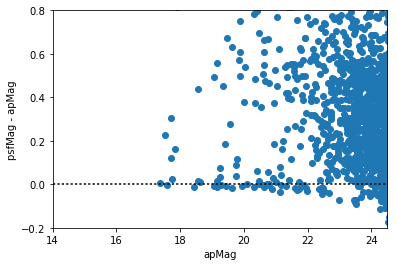

In [19]:
with afwImageUtils.CalibNoThrow():
    if False:
        apMag = exposure.getCalib().getMagnitude(sources["base_CircularApertureFlux_12_0_flux"])
    else:
        apMag = exposure.getCalib().getMagnitude(sources.getApFlux())

    psfMag = exposure.getCalib().getMagnitude(sources.getPsfFlux())

plt.plot(apMag[good], (psfMag - apMag)[good], 'o')

plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 24.5)
plt.ylim(-0.2, 0.8)

plt.xlabel("apMag")
plt.ylabel("psfMag - apMag")

plt.show()

This doesn't look like modern CCD data as there's no brighter-fatter effect.  That's because we corrected it at the pixel level as part of the instrumental signature effect.

In [20]:
if True:
    disp2.mtv(exposure, title='post calib')
else:
    disp2.erase()

#### Show something about the measurements

In [21]:
with disp2.Buffering():
    for s in sources[good]:
        disp2.dot('+', *s.getCentroid(),
                    ctype=afwDisplay.CYAN if s.get("flags_negative") else afwDisplay.GREEN)

In [22]:
if False:
    radii = algMetadata.get("base_CircularApertureFlux_radii")

    with disp2.Buffering():
        for s in sources[good]:
            for radius in radii:
                disp2.dot('o', *s.getCentroid(), size=radius, ctype=afwDisplay.YELLOW)

### Astropy

Hmm, this doesn't seem to be in 13.0 (it is in w_2017_15)

In [23]:
sources[good].copy(deep=True).asAstropy()

AttributeError: 'SourceCatalog' object has no attribute 'asAstropy'